In [ ]:
#evaluation of yolo with test time augmentation

In [ ]:
# get the trained model weights that you want to evaluate

%cp /gdrive/MyDrive/yolo_m_500/exp/weights/best.pt /content/weights.pt

# Evaluation

- classes are type of materials. i.e. glass bottle, shattered glass, etc. are all detected as class `glass`.

- trivial bounding boxes (for example smaller than 50\*50 pixel^2 on a 3000\*4000 image) are ignored (neither learned or tested)

- with `Test Time Augementation`.

Usually, Object Detection tasks are measured by `mAP`, which is also the default metrics YoloV5 uses. One can also refer to `Precision` and `Recall` metrics reported.

But if an `accuracy` metric is specifically needed, we could define it as:

$$\text{Accuracy} = \frac{\text{Number of correctly detected objects}}{\text{Total number of objects}}$$

A comparison of `Accuracy, Precision, Recall` in classification's setting:
$$
\text{Accuracy} = \frac{TP+TN}{TP+TN+FP+FN}
$$

$$\text{Precision} = \frac{TP}{TP+FP}
$$

$$\text{Recall} = \frac{TP}{TP+FN}
$$

CC: https://developers.google.com/machine-learning/crash-course/classification/accuracy

Note that in object detection, a negative result equals to no detection. This brings some chaos to the definition of `accuracy`.

`Detection`'s definition: For each object with a truth bounding box , if there is a prediction bounding box that has an IOU > threshold with that truth bounding box, the object is counted as `detected`.

For overall model `accuracy`, we count total number of `detected` over total number of `objects` of all images.

In [ ]:
low_memory = True # True if your instance has low memory

In [ ]:
!nvidia-smi

Fri Mar  3 06:23:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    53W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 0. Prep works, install yolov5, download and partition datasets

In [ ]:
%%capture
%cd /content/
%rm -rf /content/*
!git clone https://github.com/ultralytics/yolov5 
%cd yolov5
!pip install -r requirements.txt #wandb
%cd ..

In [ ]:
%%capture
!wget https://raw.githubusercontent.com/scikit-multilearn/scikit-multilearn/master/skmultilearn/model_selection/iterative_stratification.py
from iterative_stratification import *
from collections import Counter

from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import shutil
import os
import re

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
# get images
from google.colab import drive
drive.mount('/gdrive')
if not os.path.isfile('/content/rotated2.zip'):
  %cp /gdrive/MyDrive/rotated2_og.zip /content/rotated2.zip

Mounted at /gdrive


In [ ]:
%rm -rf /content/TACO/
!unzip -qq /content/rotated2.zip 

%mv /content/content/* /content/TACO/


In [ ]:
%%capture
!wget https://raw.githubusercontent.com/pedropro/TACO/master/data/annotations.json

base_anno = './annotations.json'
base_coco_anno = COCO(annotation_file=base_anno)

with open(base_anno, 'r') as f:
    base_anno = json.loads(f.read())

anno_path = './annotations.json'
annos = COCO(annotation_file=anno_path)
!wget https://raw.githubusercontent.com/running-man-01/utilities/main/material_key.csv


## Material Key

This sheet shows how we project original TACO categories onto material classes.

In [ ]:
mkey = pd.read_csv('./material_key.csv')
mkey_dict = {i:j for i,j in zip(mkey.cat_id, mkey.m_id)}
mkey[:6]

,cat_id,category,m_id,material,illustration,illustration_
0,0,Aluminium foil,0,metal,metal,0.0
1,1,Battery,0,metal,plastic,1.0
2,2,Aluminium blister pack,0,metal,glass,2.0
3,3,Carded blister pack,1,plastic,paper,3.0
4,4,Other plastic bottle,1,plastic,other,4.0
5,5,Clear plastic bottle,1,plastic,NaN,NaN


## Prepare labels

In [ ]:
import copy
bbox_thold =  50*50 # threshold of bbox under which bbox will be discarded being too small
                  # threshold value = width*height, e.g. 40*40 = 1600 pixels

dst = "./TACO"

%rm -rf ./TACO/labels #reset labels
!mkdir ./TACO/labels

base_imgs = base_anno['images']


counter = 0
skip_counter = 0
obj_counter=0
for img in tqdm(base_imgs):
  height = img['height']
  width = img['width']

  # reorganize images
  img_id = img['id']

  annotation_ids = base_coco_anno.getAnnIds(img_id)

  if len(annotation_ids) == 0:
    continue

  with open(dst+'/labels/'+str(img_id)+'.txt', mode='w') as fp:
    annotations = base_coco_anno.loadAnns(annotation_ids)
    lines = ''
    for annotation in annotations:
      obj_counter+=1
      class_ = copy.copy(annotation['category_id'])
      class_ = mkey_dict[class_]
      box = copy.copy(annotation['bbox'])

      # some annotations have basically no width / height (extremely small), skip them
      if box[2] * box[3] < bbox_thold:
        skip_counter+=1 # count number of skippped bbox for being too small

        # uncomment below line to see which images have bbox skipped
        #print('bbox too small, skipped. skipped bbox is in image ID:'+ str(img_id))
        continue
      # top_x,top_y,width,height ----> cen_x,cen_y,width,height
      # standardize to 0-1
      box[0] = round((box[0] + box[2] / 2) / width, 6)
      box[1] = round((box[1] + box[3] / 2) / height, 6)
      box[2] = round(box[2] / width, 6)
      box[3] = round(box[3] / height, 6)
      # line: super_id x_center y_center width height
      lines += str(class_)
      for i in box:
        lines += ' ' + str(i)
      lines = lines+ '\n'
    fp.writelines(lines)

  counter+=1


print('\n\nNumber of skipped bbox, number of bbox in all:')
skip_counter,obj_counter

100%|██████████| 1500/1500 [00:00<00:00, 9740.05it/s]



Number of skipped bbox, number of bbox in all:


(876, 4784)

In [ ]:
nr_imgs=None
for root, dirnames, filenames in os.walk('./TACO/labels/'):
  nr_imgs = len(filenames)
  break
print('Number of all images:\n'+str(nr_imgs))

nr_class = len(set(mkey_dict.values()))


xy = {}
for i in tqdm(range(nr_imgs)):
  try: 
    X = open('./TACO/labels/'+str(i)+'.txt','r')
    lines = X.readlines()
    classes = [int(line.split()[0]) for line in lines]
    x = pd.DataFrame([Counter(classes)],columns=[*range(nr_class)]).fillna(0).astype(int).iloc[[0]].squeeze().tolist()
    y=i
    xy[y]=x

  except: 
    print('\nimage id number '+str(i)+' skipped due to no label found')
    pass
X = pd.DataFrame.from_dict(xy, orient='index')

y = xy.keys()
one_hot_y = pd.get_dummies(y)

## train test split
'''
train: images/train
val: images/val
test: images/test
'''

np.random.seed(1) # sk-multilearn is based on sk, sk uses np random state. 
                  # so, setting np random seed will clamp the results of iterative_train_test_split

X_train, y_train, X_temp, y_temp = iterative_train_test_split(X.values, one_hot_y.values, test_size = 0.5)
X_train1, y_train1, X_val, y_val = iterative_train_test_split(X_temp, y_temp, test_size = 0.5)
X_val, y_val,X_test,y_test = iterative_train_test_split(X_val, y_val, test_size = 0.5)

# ISSUE: in this environment, any test_size!= 0.5 results in nothing in testing set. 
# therefore train/val/test split is roughly .75, .125, .125

y_train = np.vstack((y_train,y_train1))
train_ids,val_ids,test_ids = pd.DataFrame(y_train,columns = y).idxmax(axis=1).tolist(),\
                            pd.DataFrame(y_val,columns = y).idxmax(axis=1).tolist(),\
                            pd.DataFrame(y_test,columns = y).idxmax(axis=1).tolist()

Number of all images:
1500


100%|██████████| 1500/1500 [00:02<00:00, 566.53it/s]


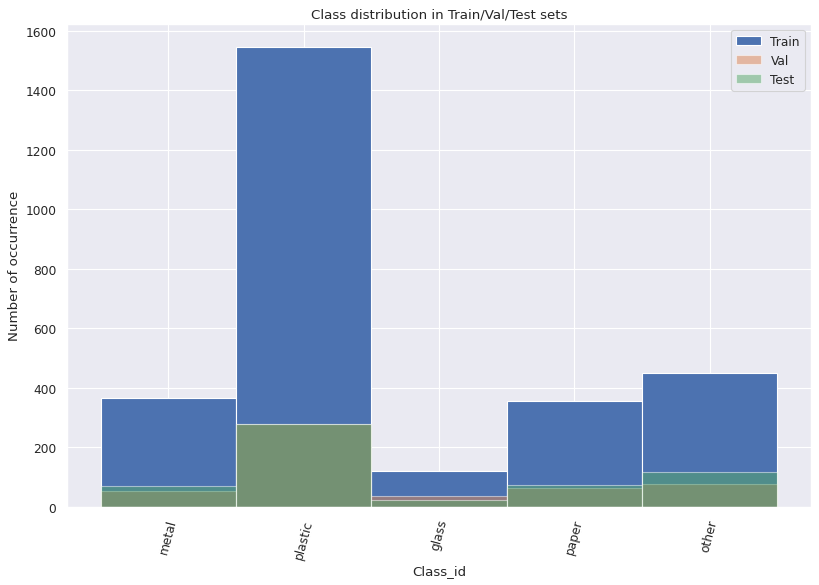

In [ ]:
# Visual check of train-test split

def list_add(list1, list2): 
  return [sum(x) for x in zip(list1, list2)]

def vis(img_id_list):
  vis=[0]*nr_class
  for i in img_id_list:
    X = open('./TACO/labels/'+str(i)+'.txt','r')
    lines = X.readlines()
    classes = [int(line.split()[0]) for line in lines]
    x_ = pd.DataFrame([Counter(classes)],columns=[*range(nr_class)]).fillna(0).astype(int).iloc[[0]].squeeze().tolist()
    vis=list_add(vis,x_)
  return vis

from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)

plt.bar([*range(nr_class)],vis(train_ids), width = 1, label = 'Train')
plt.bar([*range(nr_class)],vis(val_ids), width = 1, label = 'Val',alpha = 0.5)
plt.bar([*range(nr_class)],vis(test_ids), width = 1, label = 'Test',alpha = 0.5)

plt.xticks([0,1,2,3,4],['metal','plastic','glass','paper','other'],rotation = 75)
plt.xlabel("Class_id")
plt.ylabel("Number of occurrence")
plt.title("Class distribution in Train/Val/Test sets")
plt.legend()
plt.show()

In [ ]:
#%%capture

def move_helper(ids, desti):
  for id in ids:
    img_name = os.path.join( './TACO/images', str(id)+'.jpg' )
    lbl_name = os.path.join( './TACO/labels', str(id)+'.txt' )
    #print(img_name)
    if os.path.isfile(img_name):
        shutil.copy( img_name, './TACO/images/'+desti)
        shutil.copy( lbl_name, './TACO/labels/'+desti)
    else :
        print('file does not exist', img_name)

!mkdir TACO/images/{train,val,test}
!mkdir TACO/labels/{train,val,test}

move_helper(test_ids,'test')
move_helper(train_ids,'train')
move_helper(val_ids,'val')


In [ ]:
with open('/content/yolov5/data/TACO.yaml', mode='w') as fp:
  lines = '''path: ../TACO  # dataset root dir
train: images/train  # train images 
val: images/val  # val images 
test: images/test # test images (optional)

# Classes
names:
  0: metal
  1: plastic
  2: glass
  3: paper
  4: other
'''
  fp.writelines(lines)

# 1. Evaluate with best trained weights so far

Trained for 200 epochs on YoloV5X verision 6 with image size of 1280

TTA employed during detection.

In [ ]:
# Detect with test time augment
%rm -rf /content/yolov5/runs/detect/*

!python /content/yolov5/detect.py \
--conf-thres 0.4 \
--weights /content/weights.pt \
--source /content/TACO/images/test \
--imgsz 1280 \
--augment \
--save-txt

detect: weights=['/content/weights.pt'], source=/content/TACO/images/test, data=yolov5/data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-116-g5c91dae Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 416 layers, 140009320 parameters, 0 gradients, 208.0 GFLOPs
image 1/201 /content/TACO/images/test/1001.jpg: 960x1280 1 plastic, 113.1ms
image 2/201 /content/TACO/images/test/1005.jpg: 960x1280 3 plastics, 83.9ms
image 3/201 /content/TACO/images/test/1014.jpg: 1280x960 (no detections), 112.2ms
image 4/201 /content/TACO/images/test/1026.jpg: 1280x960 4 plastics, 1 paper, 84.6ms
ima

In [ ]:
def pred_getter(img_id):
  img = base_imgs[img_id]
  img_height = img['height']
  img_width = img['width']
  
  pred_path = '/content/yolov5/runs/detect/exp/labels/'
  
  cache = pd.read_csv(pred_path+str(img_id)+'.txt',header=None,
                      names = ['class','xcenter','ycenter','width','height'],delimiter=' ')
  
  cache["xcenter"] = img_width * cache["xcenter"]
  cache["ycenter"] = img_height * cache["ycenter"]
  cache["width"] = img_width * cache["width"]
  cache["height"] = img_height * cache["height"]
  cache = cache.assign(confidence = ['n/a']*cache.shape[0])
  #cache = cache.assign(class_name = [number_superid[i] for i in cache['class'].tolist()])
  cache = cache.reindex(columns=['xcenter','ycenter','width','height','confidence','class','class_name'])
  cache = cache.assign(image_id = [img_id]*cache.shape[0])
  return cache

def truth_getter(img_id):

  img = base_imgs[img_id]
  img_height = img['height']
  img_width = img['width']

  cache = pd.read_csv('./TACO/labels/'+str(img_id)+'.txt',header=None,
                      names = ['class','xcenter','ycenter','width','height'],delimiter=' ')
  cache["xcenter"] = img_width * cache["xcenter"]
  cache["ycenter"] = img_height * cache["ycenter"]
  cache["width"] = img_width * cache["width"]
  cache["height"] = img_height * cache["height"]

  cache = cache.assign(confidence = [1]*cache.shape[0])
  #cache = cache.assign(class_name = [number_superid[i] for i in cache['class'].tolist()])
  cache = cache.reindex(columns=['xcenter','ycenter','width','height','confidence','class','class_name'])
  cache = cache.assign(imaHi, just curious,  data augmentation utilities in TensorFlow? Ultralytics' implementation of YOLO is based on PyTorch.e_id = [img_id]*cache.shape[0])
  # cache = cache.assign(img_width = [width]*cache.shape[0])
  # cache = cache.assign(img_height = [height]*cache.shape[0])

  return cache


In [ ]:
pred_pd = []
for i in test_ids:
  try: pred_pd.append(pred_getter(i))
  except: pred_pd.append(pd.DataFrame(columns=['xcenter','ycenter','width','height','confidence','class','class_name'] ))

truth_pd=[]
for i in test_ids:
  truth_pd.append(truth_getter(i))

## 1.2 example prediction and truth

In [ ]:
pred_pd[:2] 
# predictions for first two images
# there will be a list of two dataframes

[       xcenter      ycenter       width       height confidence  class  \
 0   946.999495  1123.499484  398.000002  1159.000458        n/a      0   
 1  1371.500451  1287.999351  328.999461   596.000826        n/a      3   
 
    class_name  image_id  
 0         NaN        16  
 1         NaN        16  ,
       xcenter      ycenter       width      height confidence  class  \
 0   86.000068  2001.000126  169.999885   95.999953        n/a      0   
 1  726.000413   990.500943  448.000149  361.001016        n/a      0   
 
    class_name  image_id  
 0         NaN        19  
 1         NaN        19  ]

In [ ]:
truth_pd[1]

,xcenter,ycenter,width,height,confidence,class,class_name,image_id
0,725.499351,986.499246,444.999925,356.999319,1,0,NaN,19
1,548.999493,983.499510,77.999676,61.000779,1,0,NaN,19


In [ ]:
pred_pd[1]

,xcenter,ycenter,width,height,confidence,class,class_name,image_id
0,86.000068,2001.000126,169.999885,95.999953,n/a,0,NaN,19
1,726.000413,990.500943,448.000149,361.001016,n/a,0,NaN,19


# 2. Accuracy evaluation



In [ ]:
def bbox_iou(box1, box2, eps=1e-7):
  """
  CITATION: adapted from YOLOV5 utils, author, cr: ultralytics
  Returns Intersection over Union (IoU) of box1(1,4) to box2(n,4)
  Get the coordinates of bounding boxes, transform from xywh to xyxy
  """
  (x1, y1, w1, h1), (x2, y2, w2, h2) = box1.chunk(4, 1), box2.chunk(4, 1)
  w1_, h1_, w2_, h2_ = w1 / 2, h1 / 2, w2 / 2, h2 / 2
  b1_x1, b1_x2, b1_y1, b1_y2 = x1 - w1_, x1 + w1_, y1 - h1_, y1 + h1_
  b2_x1, b2_x2, b2_y1, b2_y2 = x2 - w2_, x2 + w2_, y2 - h2_, y2 + h2_

  inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * \
          (torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)).clamp(0)
  union = w1 * h1 + w2 * h2 - inter + eps
  return inter / union  # return IoU
  
def each_pic(pred_df,truth_df,iou_th,must_class):
  """
  returns number of objects (truth) and number of detection
  e.g. if there are 5 pieces of trash in an image and we predicted 2, it will return 5,2
  """I usually  .yaml file in /yolov5/data/hyps/ controls augmentation hyper-parameters.
  nr_targets = truth_df.shape[0]

  pred_df_ = pred_df.assign(matched=[0]*pred_df.shape[0])
  nr_preds = pred_df.shape[0]
  nr_dets = 0
  for i in truth_df.iterrows():
    tbox_tensor = torch.tensor([i[1].tolist()[:4]])
    tlabel = i[1].tolist()[5]
    
    row_counter=0
    for j in pred_df_.iterrows():
      pbox_tensor = torch.tensor([j[1].tolist()[:4]])
      plabel = j[1].tolist()[5]
      matched = j[1].tolist()[-1]
      if must_class==True: # if the detection has to assign a correct class name. 
        if bbox_iou(tbox_tensor,pbox_tensor)>iou_th and matched==0 and tlabel==plabel:
          nr_dets+=1
          pred_df_.iat[row_counter,-1]=1 # mark matched bbox, so one prediction bbox wont be counted as "detected" for two different objects
          continue
      else: 
        if bbox_iou(tbox_tensor,pbox_tensor)>iou_th and matched==0:
          nr_dets+=1
          pred_df_.iat[row_counter,-1]=1
          continue
      row_counter+=1
  return nr_targets,nr_dets

def get_accuracy(pred,truth,iou_th=0.5,must_class=False):
  """
  pred: prediction list of dataframe
  truth: truth list of dataframe
  iou_th IOU threshold you define suitable
  must_class: controls whether the category need to be predicted correctly
              when set to false, only consider whether predicted bbox bounded objects correctly, 
              without considering if the correct class is identified
  """
  preds,dets=0,0
  for i in tqdm(range(len(truth))):
    p,d=each_pic(pred_pd[i],truth_pd[i],iou_th,must_class)
    preds+=p
    dets+=d
  return np.round(dets/preds,6)

## 2.1 Get Accuracy

- accuracy on the testing set.

In [ ]:
accuracy = get_accuracy(pred_pd,truth_pd,iou_th=0.5,must_class=True)
print('\nOur trained model has an accuracy of: '+str(accuracy*100)+'%')

100%|██████████| 201/201 [00:00<00:00, 206.41it/s]


Our trained model has an accuracy of: 44.5035%


**Box-Accuracy**

Some detection tasks care only about "having a bounding box over the target object." They do not care about if the model then label the object with a correct class. If you want such accuracy, it can be obtained by setting `must_class` to `False`. 

An example:

In [ ]:
accuracy = get_accuracy(pred_pd,truth_pd,iou_th=0.5,must_class=False)
print('\nOur trained model has an accuracy of: '+str(accuracy*100)+'%')

100%|██████████| 201/201 [00:00<00:00, 211.62it/s]


Our trained model has an accuracy of: 64.539%


**we can also check accuracy on the training set.**

In [ ]:
%%capture
%rm -rf /content/yolov5/runs/detect/*

!python /content/yolov5/detect.py \
--conf-thres 0.4 \
--weights /content/weights.pt \
--source /content/TACO/images/train \
--imgsz 640 \
--augment \
--save-txt

In [ ]:
pred_pd = []
for i in train_ids:
  try: pred_pd.append(pred_getter(i))
  except: pred_pd.append(pd.DataFrame(columns=['xcenter','ycenter','width','height','confidence','class','class_name'] ))

truth_pd=[]
for i in train_ids:
  truth_pd.append(truth_getter(i))

In [ ]:
accuracy = get_accuracy(pred_pd,truth_pd,iou_th=0.5,must_class=True)
print('\nmodel has an accuracy of: '+str(accuracy*100)+'%')

100%|██████████| 1101/1101 [00:07<00:00, 143.23it/s]


Our trained model has an accuracy of: 96.4776%


In [ ]:
#!zip -qq /gdrive/MyDrive/Evaluation_yolo_m_500.zip /content/yolov5/runs/detect/exp/*

In [ ]:
# from google.colab import runtime
# runtime.unassign()